In [1]:
# Import dependencies
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas.io.sql as sqlio
import psycopg2

from datetime import datetime
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from scipy.stats import skew
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
import xgboost as xgb

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from config_user_dta import config

from sklearn.model_selection import RandomizedSearchCV

In [2]:
# Get the config params
params_ = config()

# Connect to the Postgres_DB:
conn = psycopg2.connect(**params_)

sql = "select * from listings;"
data_df = sqlio.read_sql_query(sql, conn)
data_df.head()

,id,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_identity_verified,neighbourhood,latitude,longitude,...,private_entrance,parking,kitchen,elevator,gym,time_since_first_review,time_since_last_review,avg_rating_overall,avg_rating_overall_cat,borough
0,1419,2008-08-08,unknown,unknown,0.0,1.0,1.0,Little Portugal,43.64590,-79.42423,...,0.0,0.0,1.0,0.0,0.0,4+ years,1+ year,5.000000,excellent,West Toronto
1,27423,2010-05-04,within a few hours,100%,0.0,1.0,1.0,South Riverdale,43.66884,-79.32725,...,1.0,1.0,1.0,0.0,0.0,4+ years,1+ year,4.911429,excellent,East Toronto
2,40456,2010-07-20,within an hour,100%,1.0,3.0,1.0,South Parkdale,43.63539,-79.44010,...,1.0,1.0,1.0,0.0,0.0,4+ years,2-6 months,4.727143,excellent,West Toronto
3,43964,2010-08-05,within an hour,100%,0.0,1.0,1.0,Wexford/Maryvale,43.74922,-79.29188,...,1.0,1.0,1.0,0.0,0.0,4+ years,2-8 weeks,4.948571,excellent,Scarborough
4,573892,2012-04-19,within an hour,100%,0.0,6.0,1.0,Waterfront Communities-The Island,43.64278,-79.37985,...,0.0,1.0,1.0,1.0,1.0,4+ years,2-8 weeks,4.845714,excellent,Downtown Toronto


### Preparing the data for modelling

In [3]:
#Create function for multi-collinearity map

def multi_collinearity_heatmap(df, figsize=(11,9)):
    
    #Set the style of the visualization
    sns.set(style="white")
    
    #Create a correlation matrix
    corr=df.corr()
    
    #Generate a mask the size of our covariance matrix
    mask=np.zeros_like(corr,dtype=np.bool)
    mask[np.triu_indices_from(mask)]=True
    
    #Set up the matplotlib figure
    f, ax=plt.subplots(figsize=figsize)
    
    #Generate a custom diverging colormap
    cmap=sns.diverging_palette(220,10, as_cmap=True)
    
    #Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidth=.5, cbar_kws={"shrink":.5}, vmax=corr[corr !=1.0].max().max())

C:\Users\carol\.conda\envs\mlenv\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':


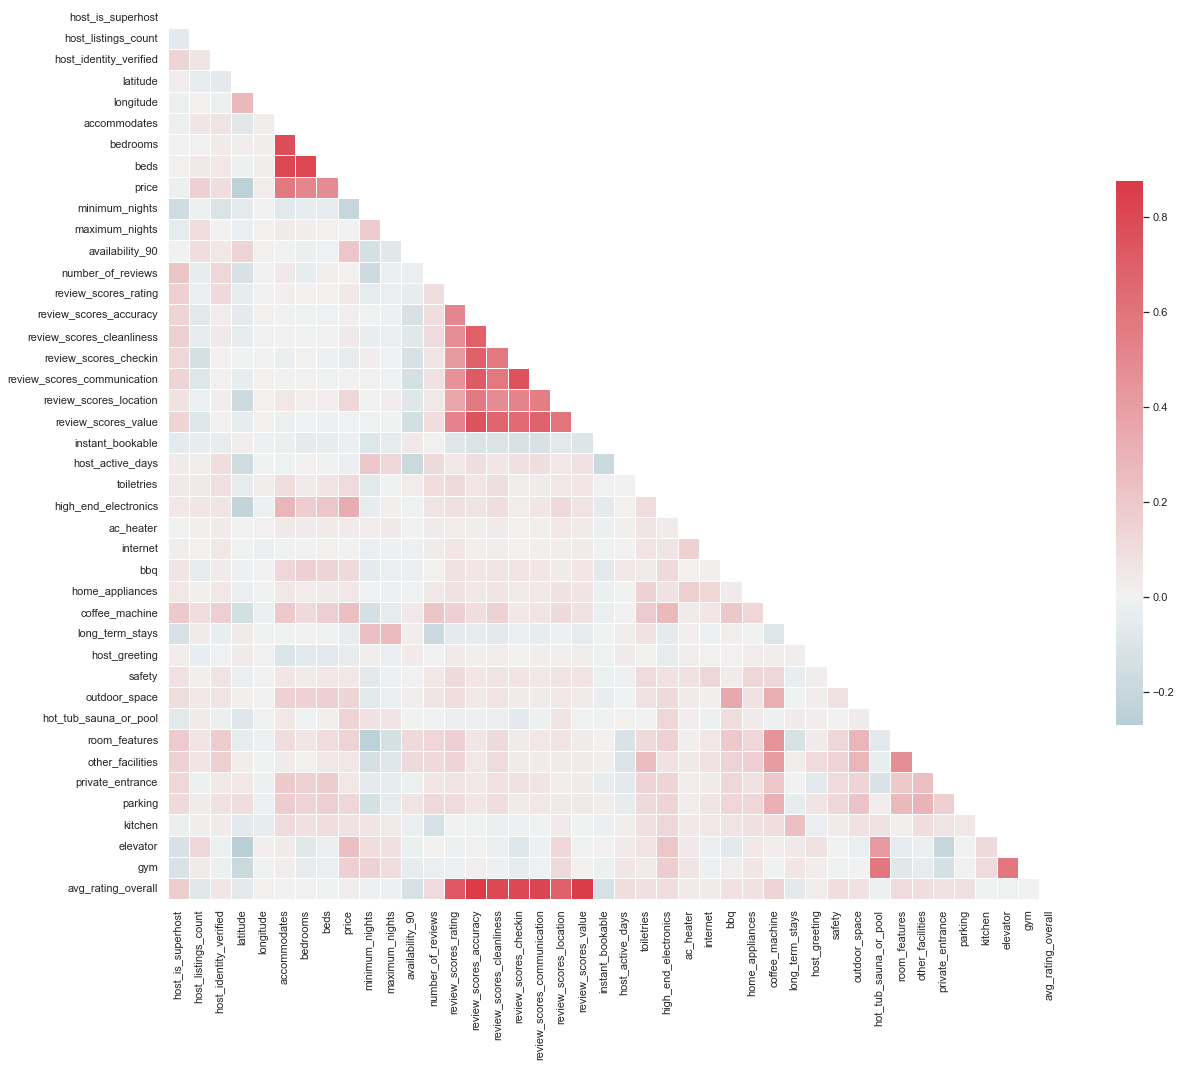

In [4]:
# Check the multi-collinearity for our data
multi_collinearity_heatmap(data_df, figsize=(20,20))

In [5]:
#Drop the columns with high correlation
data_df.drop(columns=["id", "latitude", "longitude","bedrooms","beds","review_scores_rating","review_scores_accuracy","review_scores_cleanliness","review_scores_checkin","review_scores_communication",
                      "review_scores_location","review_scores_value","room_type","avg_rating_overall_cat","host_since","first_review","last_review"],inplace=True)

In [6]:
# Numerical Features to be included in the model
num_col=data_df[["host_is_superhost","host_listings_count", "host_identity_verified", "instant_bookable","accommodates","minimum_nights","maximum_nights","number_of_reviews","availability_90",
                    "toiletries", "high_end_electronics","ac_heater","internet","bbq","home_appliances","coffee_machine","long_term_stays","host_greeting","safety","outdoor_space","hot_tub_sauna_or_pool","room_features","other_facilities","private_entrance",
                    "parking", "kitchen", "elevator","price","host_active_days","avg_rating_overall","gym"]]

host_is_superhost
1.130586505193129


C:\Users\carol\.conda\envs\mlenv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


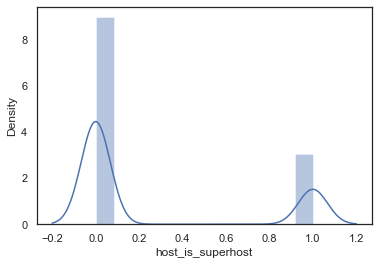

host_listings_count
9.068115579114009


C:\Users\carol\.conda\envs\mlenv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


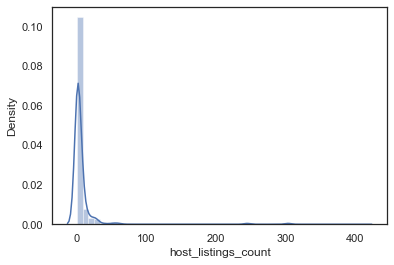

C:\Users\carol\.conda\envs\mlenv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


host_identity_verified
-2.5159357141256744


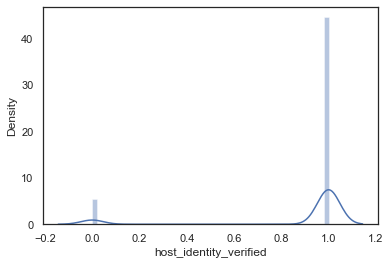

instant_bookable
0.9163731963267697


C:\Users\carol\.conda\envs\mlenv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


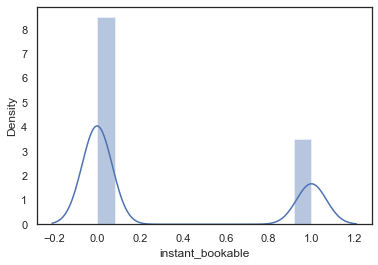

accommodates
1.9577759246495634


C:\Users\carol\.conda\envs\mlenv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


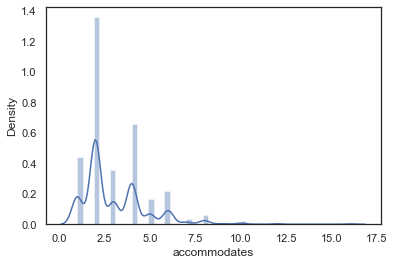

C:\Users\carol\.conda\envs\mlenv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


minimum_nights
0.6547314975972046


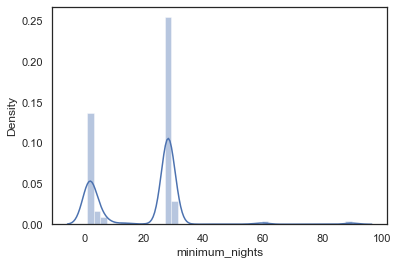

maximum_nights
-0.19139143259137995


C:\Users\carol\.conda\envs\mlenv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


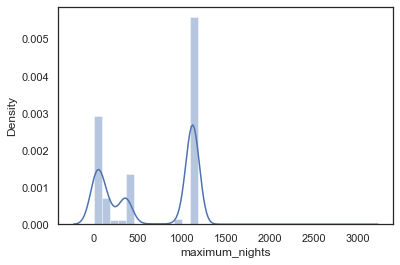

number_of_reviews
3.9993035505373693


C:\Users\carol\.conda\envs\mlenv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


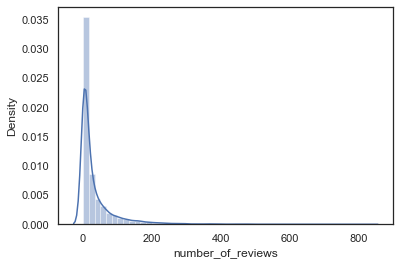

C:\Users\carol\.conda\envs\mlenv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


availability_90
0.8598250018000996


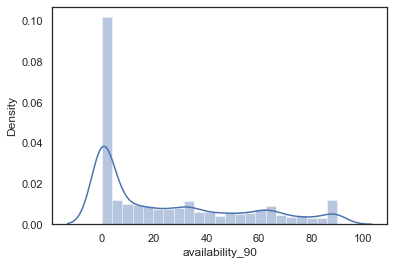

toiletries
-1.3840408717960864


C:\Users\carol\.conda\envs\mlenv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


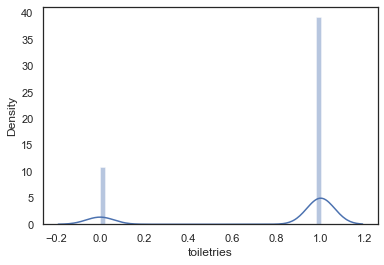

high_end_electronics
-1.2182925537666538


C:\Users\carol\.conda\envs\mlenv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


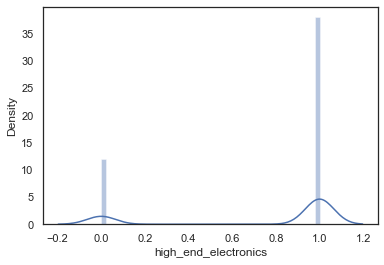

C:\Users\carol\.conda\envs\mlenv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


ac_heater
-7.263184327561099


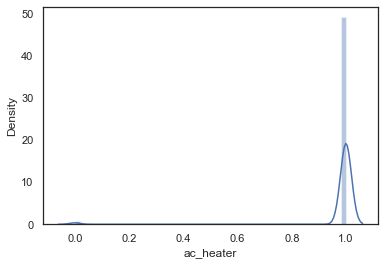

internet
-10.85213189520914


C:\Users\carol\.conda\envs\mlenv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


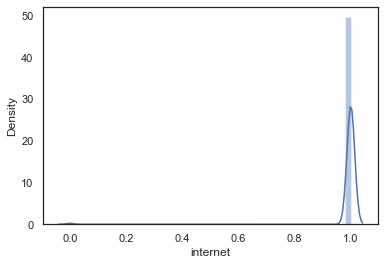

C:\Users\carol\.conda\envs\mlenv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


bbq
2.005628748159507


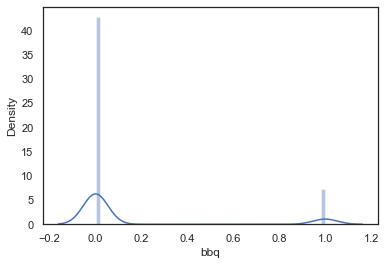

home_appliances
-7.725353167001943


C:\Users\carol\.conda\envs\mlenv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


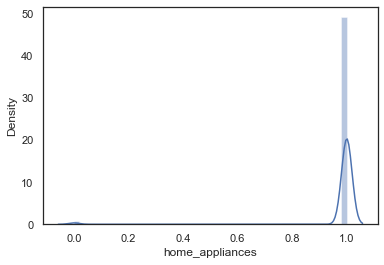

coffee_machine
-0.30915790700882567


C:\Users\carol\.conda\envs\mlenv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


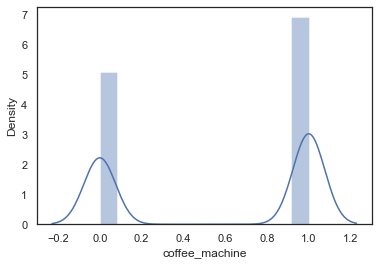

long_term_stays
-3.7009025993688422


C:\Users\carol\.conda\envs\mlenv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


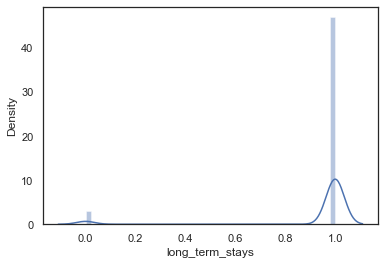

C:\Users\carol\.conda\envs\mlenv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


host_greeting
2.16138284587624


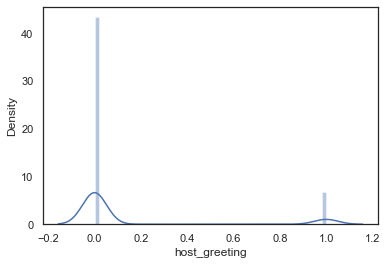

safety
-5.652270073411584


C:\Users\carol\.conda\envs\mlenv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


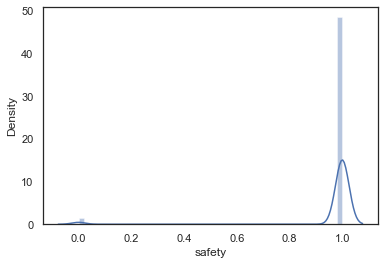

outdoor_space
0.3002299516679605


C:\Users\carol\.conda\envs\mlenv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


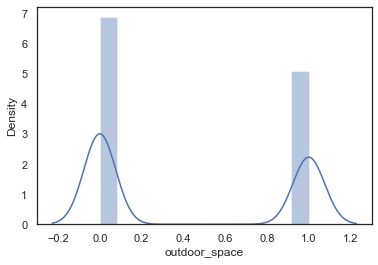

hot_tub_sauna_or_pool
1.716011490693121


C:\Users\carol\.conda\envs\mlenv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


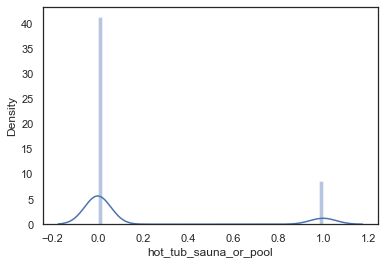

room_features
-0.8589863485833829


C:\Users\carol\.conda\envs\mlenv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


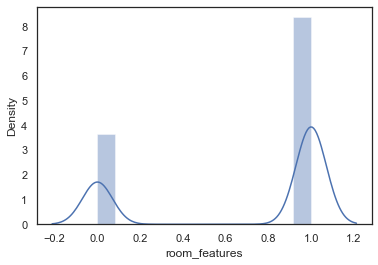

other_facilities
-1.3557775969815575


C:\Users\carol\.conda\envs\mlenv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


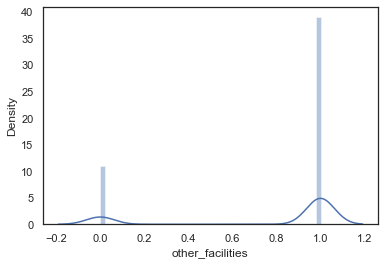

C:\Users\carol\.conda\envs\mlenv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


private_entrance
0.21533202671759108


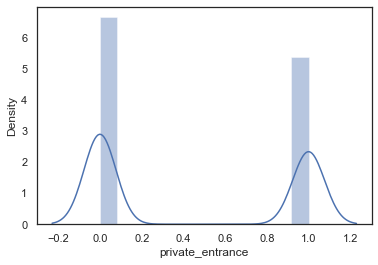

parking
-1.1957514294333669


C:\Users\carol\.conda\envs\mlenv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


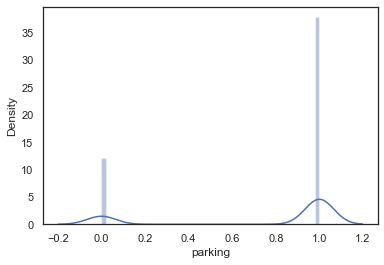

kitchen
-3.3461620954039706


C:\Users\carol\.conda\envs\mlenv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


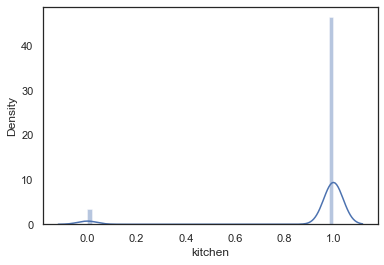

elevator
0.7429563200604823


C:\Users\carol\.conda\envs\mlenv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


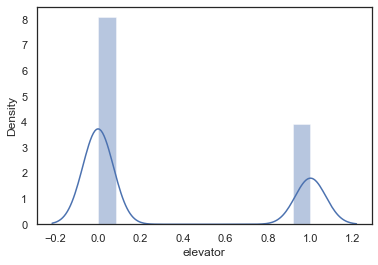

price
1.9584624110041686


C:\Users\carol\.conda\envs\mlenv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


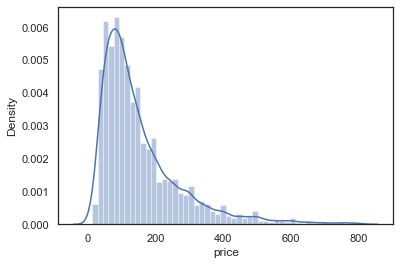

host_active_days
0.051524034471057835


C:\Users\carol\.conda\envs\mlenv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


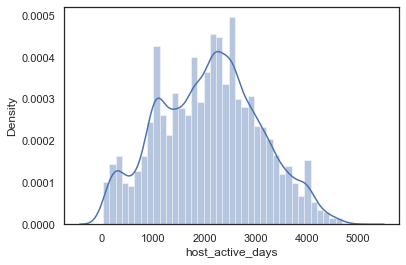

C:\Users\carol\.conda\envs\mlenv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


avg_rating_overall
-5.191689129451892


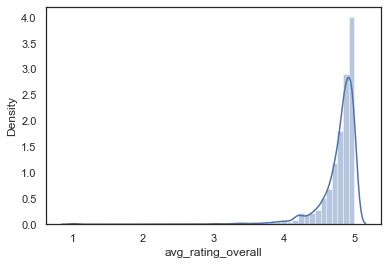

gym
1.2530365560802048


C:\Users\carol\.conda\envs\mlenv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


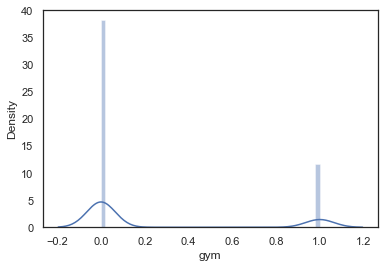

In [7]:
#Check the skewness in the numerical columns
for col in num_col:
    print(col)
    print(skew(num_col[col]))
    
    plt.figure()
    sns.distplot(num_col[col])
    plt.show()

In [8]:
# Log transforming columns to reduce skewness
num_col = [i for i in num_col if i not in ['coffee_machine', 'host_active_days']] # Removing items not to be transformed

for col in num_col:
    data_df[col] = data_df[col].astype('float64').replace(0.0, 0.01).replace(0,0.01) # Replacing 0s with 0.01
    data_df[col] = np.log(data_df[col])

In [9]:
# Processng Categorical Features
data_df=pd.get_dummies(data_df,columns=["host_response_time","host_response_rate","time_since_first_review","time_since_last_review","borough","neighbourhood","property_type"])

In [10]:
# #Create Target and Feature Variables for Machine Learning
X=data_df.drop(["price"], axis=1)
y=data_df["price"]


# #Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test= train_test_split(X,y, random_state=78)

In [11]:
# Create a StandardScaler Instance
scaler=StandardScaler()

# # #Fit the StandardScaler
X_scaler=scaler.fit(X_train)

# # #Scale the data
X_train_scaled=X_scaler.transform(X_train)
X_test_scaled=X_scaler.transform(X_test)

### Linear Regression Model

In [12]:
# Run the Linear Regression model
lr_model=LinearRegression()
lr_model.fit(X_train_scaled, y_train)
training_pred=lr_model.predict(X_train_scaled)
predictions=lr_model.predict(X_test_scaled)
r2_score(y_test,predictions)

rmse_training=np.sqrt(mean_squared_error(y_train,training_pred))
rmse_model=np.sqrt(mean_squared_error(y_test, predictions))
print('RMSE train: %.3f' % rmse_training)
print('RMSE test: %.3f' % rmse_model)
print('R^2 train: %.3f' % (r2_score(y_train,training_pred )))
print('R^2 test: %.3f' % (r2_score(y_test, predictions)))


RMSE train: 0.391
RMSE test: 0.393
R^2 train: 0.685
R^2 test: 0.682


### Support Vector Regression Model

In [13]:
# # Run the Support Vector Regression model
svr_model=SVR(kernel="rbf", C=1.5, epsilon=0.2)
svr_model.fit(X_train_scaled, y_train)
training_pred=svr_model.predict(X_train_scaled)
predictions=svr_model.predict(X_test_scaled)
r2_score(y_test,predictions)

rmse_training=np.sqrt(mean_squared_error(y_train,training_pred))
rmse_model=np.sqrt(mean_squared_error(y_test, predictions))
print('RMSE train: %.3f' % rmse_training)
print('RMSE test: %.3f' % rmse_model)
print('R^2 train: %.3f' % (r2_score(y_train,training_pred )))
print('R^2 test: %.3f' % (r2_score(y_test, predictions)))

RMSE train: 0.287
RMSE test: 0.394
R^2 train: 0.830
R^2 test: 0.681


### GradientBoostingRegressor

In [14]:
# Run the GradientBoosting Regression model
gbr_model=GradientBoostingRegressor()
gbr_model.fit(X_train_scaled, y_train)
training_pred=gbr_model.predict(X_train_scaled)
predictions=gbr_model.predict(X_test_scaled)
r2_score(y_test,predictions)

rmse_training=np.sqrt(mean_squared_error(y_train,training_pred))
rmse_model=np.sqrt(mean_squared_error(y_test, predictions))
print('RMSE train: %.3f' % rmse_training)
print('RMSE test: %.3f' % rmse_model)
print('R^2 train: %.3f' % (r2_score(y_train,training_pred )))
print('R^2 test: %.3f' % (r2_score(y_test, predictions)))

RMSE train: 0.353
RMSE test: 0.363
R^2 train: 0.742
R^2 test: 0.728


### RandomForestRegressor

In [15]:
# Run the RandomForest Regression model
rfr_model=RandomForestRegressor()
rfr_model.fit(X_train_scaled, y_train)
training_pred=rfr_model.predict(X_train_scaled)
predictions=rfr_model.predict(X_test_scaled)
r2_score(y_test,predictions)

rmse_training=np.sqrt(mean_squared_error(y_train,training_pred))
rmse_model=np.sqrt(mean_squared_error(y_test, predictions))
print('RMSE train: %.3f' % rmse_training)
print('RMSE test: %.3f' % rmse_model)
print('R^2 train: %.3f' % (r2_score(y_train,training_pred )))
print('R^2 test: %.3f' % (r2_score(y_test, predictions)))

RMSE train: 0.136
RMSE test: 0.356
R^2 train: 0.962
R^2 test: 0.738


### ExtraTreesRegressor

In [16]:
# Run the ExtraTrees Regression model
etr_model=ExtraTreesRegressor(n_estimators=100,random_state=37)
etr_model.fit(X_train_scaled, y_train)
training_pred=etr_model.predict(X_train_scaled)
predictions=etr_model.predict(X_test_scaled)
r2_score(y_test,predictions)

rmse_training=np.sqrt(mean_squared_error(y_train,training_pred))
rmse_model=np.sqrt(mean_squared_error(y_test, predictions))
print('RMSE train: %.3f' % rmse_training)
print('RMSE test: %.3f' % rmse_model)
print('R^2 train: %.3f' % (r2_score(y_train,training_pred )))
print('R^2 test: %.3f' % (r2_score(y_test, predictions)))

RMSE train: 0.000
RMSE test: 0.362
R^2 train: 1.000
R^2 test: 0.730


### XGBoostRegressor

This model is giving us the best result in terms of RMSE score and R2 value. We will try hyperparameter tuning to see if we can achieve further improvements.

In [17]:
# Run the XGBoost Regression model
xgbr_model=xgb.XGBRegressor(max_depth=5)
xgbr_model.fit(X_train_scaled, y_train)
training_pred=xgbr_model.predict(X_train_scaled)
predictions=xgbr_model.predict(X_test_scaled)
r2_score(y_test,predictions)

rmse_training=np.sqrt(mean_squared_error(y_train,training_pred))
rmse_model=np.sqrt(mean_squared_error(y_test, predictions))
print('RMSE train: %.3f' % rmse_training)
print('RMSE test: %.3f' % rmse_model)
print('R^2 train: %.3f' % (r2_score(y_train,training_pred )))
print('R^2 test: %.3f' % (r2_score(y_test, predictions)))

RMSE train: 0.271
RMSE test: 0.353
R^2 train: 0.848
R^2 test: 0.743


### Using RandomizedSearchCV to test hyperparameters

In [18]:
# Read hyperparameters
xgbr_model.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 5,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [19]:
# Create a dictionary with hyperparemeters and possible values
param_grid = {
    'max_depth':[i for i in range(3,10)],
    'min_child_weight': [i for i in range(1,6)],
    'colsample_bytree':[i/10.0 for i in range(6,10)],
    'subsample':[i/10.0 for i in range(6,10)],
    'gamma':[i/10.0 for i in range(0,5)],
    'reg_alpha':[0, 0.5],
    'reg_lambda':[1, 0],
    'n_estimators': [100,250,500,1000],
    'eta':[0.05,0.1,0.2],
    'learning_rate':[0.1, 0.5]
}

# create the model for RandomizedSearchCV
xgb_model = xgb.XGBRegressor(random_state=0, verbosity=1)

In [20]:
# Define the number of interactions
n_iter = 100

search = RandomizedSearchCV(estimator=xgb_model,
                               param_distributions=param_grid,
                               n_iter=n_iter
                              )
best_model = search.fit(X_train_scaled, y_train)

# Save and print the best parameters
best_param = best_model.best_params_
print('Optimum parameters', best_param)

Optimum parameters {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 250, 'min_child_weight': 2, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.4, 'eta': 0.1, 'colsample_bytree': 0.6}


In [21]:
# Run the Optimized XGBoost Regression model
opt_model=xgb.XGBRegressor(random_state=0, verbosity=1,**best_param)

opt_model.fit(X_train_scaled, y_train)
training_pred=opt_model.predict(X_train_scaled)
predictions=opt_model.predict(X_test_scaled)
r2_score(y_test,predictions)

rmse_training=np.sqrt(mean_squared_error(y_train,training_pred))
rmse_model=np.sqrt(mean_squared_error(y_test, predictions))
print('RMSE train: %.3f' % rmse_training)
print('RMSE test: %.3f' % rmse_model)
print('R^2 train: %.3f' % (r2_score(y_train,training_pred )))
print('R^2 test: %.3f' % (r2_score(y_test, predictions)))

RMSE train: 0.273
RMSE test: 0.346
R^2 train: 0.846
R^2 test: 0.754


In [22]:
# Show the top ten feature importances according to the XGBoost Model
ft_weights_xgb_reg = pd.DataFrame(opt_model.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', inplace=True)

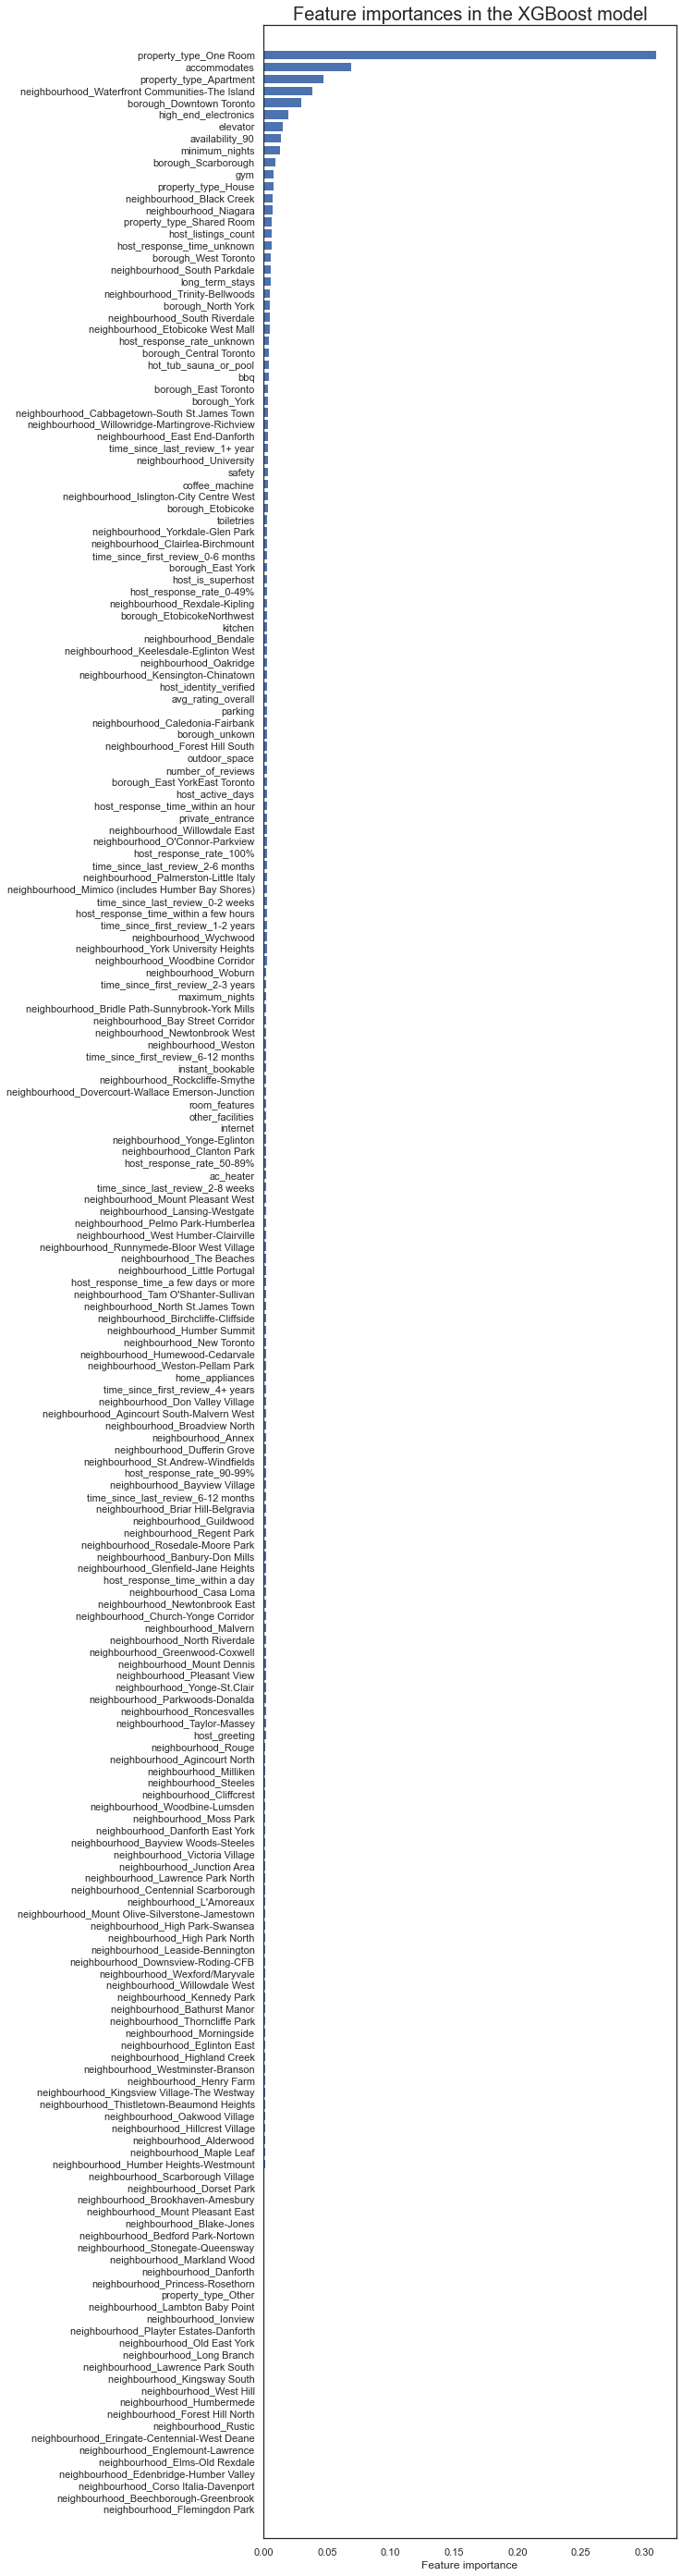

In [23]:
# Plotting feature importances
plt.figure(figsize=(8,50))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=20)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()